### Import modules

In [2]:
# TensorFlow and tf.keras
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

### load data 
- #### dataset (x: imdb article -> y: text type)
- #### word2idx dict (key: word; value: index)

사전을 만들고 등록을 시킴. indexing 작업. hate, love 등의 단어를 one-hot-coding으로 데이터화 해줌. 하지만 영화 리뷰는 한 단어를 처리하는 것에서 끝나는 것이 아닌 전체 문장을 기준으로 분석해야 함. 따라서 단어 2개, 즉 입력이 2개 들어간다고 해서 결과값도 2개가 나오면 안됨. 결과 벡터는 항상 하나가 되게 하는 collapse(평균화) 작업이 필요함.
imdb에 나타나는 단어는 10000개 보다 훨씬 많지만 input_size를 10000개로 설정해주면서 나머지 데이터는 unknown 처리해줌.
리뷰마다 단어개수 다른데 한 리뷰 단어개수를 256로 지정하고 남으면 자르고 부족하면 pad추가.

In [5]:
vocab_size = 10000
(x_train, y_train), (x_test, y_test) = tensorflow.keras.datasets.imdb.load_data(num_words=vocab_size)
word2idx = tensorflow.keras.datasets.imdb.get_word_index()

In [6]:
x_train.shape

(25000,)

In [7]:
y_train[0]

1

### modifiy word2idx dict (to reflect x_train, x_text)

word2idx.items()는 단어와 숫자의 조합인 index를 보여줌. forloop를 하면 총 88584번 돌아감.

In [9]:
len(word2idx.items())

88584

k:v+3에서 3을 더하는 부분이 빠진다면 똑같은 값을 입력하고 같은 값이 나오기 때문에 변하는 것이 없음.
모든 index의 value값에 3을 추가한 것과 같음. 사전에 새로운 단어를 등록하기 위해 자리를 확보한 것.

In [10]:
word2idx = {k:v+3 for k, v in word2idx.items()}
word2idx['<PAD>'] = 0
word2idx['<START>'] = 1
word2idx['<UNK>'] = 2
word2idx['<UNUSED>'] = 3

In [11]:
len(word2idx.items())

88588

### create idx2word: inverse of word2idx

v:k는 index값이 앞에 오고 key값이 뒤로 가게 됨. 이는 단어를 넣으면 value를 알수 있는 사전과, value값을 넣으면 단어를 알 수 있는 사전을 따로 만들어야 하기 때문.

In [15]:
idx2word = {v:k for k, v in word2idx.items()}

In [16]:
len(x_train[0])

218

### padding x_train, x_test

x의 길이를 256으로 통일하는 작업. post는 뒷부분에 padding을 하라는 것.

In [17]:
x_train = pad_sequences(x_train, value=word2idx['<PAD>'], padding='post', maxlen=256)
x_test = pad_sequences(x_test, value=word2idx['<PAD>'], padding='post', maxlen=256)

In [18]:
len(x_train[0])

256

### create model

embedding은 256의 숫자를 256x10000의 2차원 matrix로 변환해주는 것. 
1의 개수는 256개. 0의 개수는 (256x10000-256)개.
hidden은 256x128의 형태가 되는데 항상 1x128 벡터의 형태를 유지해야 하므로 한 번의 작업당 256개의 숫자를 평균해야 하고 이것을 총 128번 하게 되는 것임. 평균을 해야 단어 각각의 판정값이 아닌 문장 전체에 대한 판정값을 결과값을 가질 수 있기 때문.

In [28]:
model = Sequential()
model.add(Embedding(vocab_size, 128))
model.add(GlobalAveragePooling1D())
model.add(Dense(1, activation='sigmoid'))

In [29]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 128)         1280000   
_________________________________________________________________
global_average_pooling1d_4 ( (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [30]:
Adam = tensorflow.keras.optimizers.Adam
model.compile(optimizer = Adam(lr=0.0005), loss='binary_crossentropy', metrics=['accuracy'])

In [31]:
print(model.input_shape)
print(model.output_shape)

(None, None)
(None, 1)


### train model

In [32]:
history = model.fit(x_train, y_train, epochs=10, validation_split=0.33)

Train on 16750 samples, validate on 8250 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
16750/16750 [==============================] - 16s 936us/sample - loss: 0.6547 - acc: 0.7111 - val_loss: 0.5860 - val_acc: 0.7879
Epoch 2/10
16750/16750 [==============================] - 14s 833us/sample - loss: 0.5047 - acc: 0.8276 - val_loss: 0.4445 - val_acc: 0.8390
Epoch 3/10
16750/16750 [==============================] - 15s 914us/sample - loss: 0.3865 - acc: 0.8691 - val_loss: 0.3687 - val_acc: 0.8628
Epoch 4/10
16750/16750 [==============================] - 14s 834us/sample - loss: 0.3212 - acc: 0.8868 - val_loss: 0.3297 - val_acc: 0.8737
Epoch 5/10
16750/16750 [==============================] - 14s 837us/sample - loss: 0.2805 - acc: 0.9011 - val_loss: 0.3068 - val_acc: 0.8805
Epoch 6/10
16750/16750 [==============================] - 14s 848us/sample - loss: 0.2511 - acc: 0.9119 - val_loss: 0.2932 - val_acc: 0.8847
Epoch 7/10
16750/16750 [==============================] -

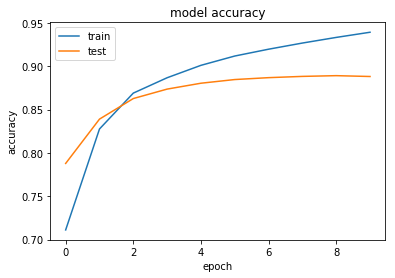

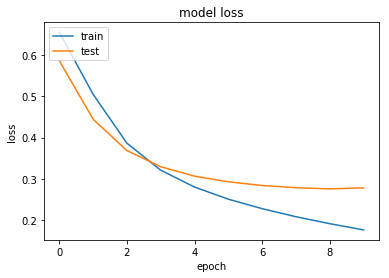

In [33]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### test model

In [34]:
model.evaluate(x_test, y_test)

25000/25000 [==============================] - 3s 132us/sample - loss: 0.2911 - acc: 0.8801


[0.2911043978023529, 0.88012]

### inference

In [35]:
testID = 100
print(' '.join([idx2word[idx] for idx in x_test[testID]]))

out = model.predict(x_test[testID].reshape(1,256))
print(y_test[testID])
print(out)

<START> a quick glance at the premise of this film would seem to indicate just another dumb <UNK> <UNK> <UNK> slash fest the type where sex equals death and the actors are all annoying stereotypes you actually want to die however delivers considerably more br br rather than focus on bare flesh and gore though there is a little of each no sex however the flick focuses on delivering impending dread <UNK> tension amidst a lovely <UNK> backdrop these feelings are further <UNK> by a cast of realistically likable characters and <UNK> that are more amoral than cardboard <UNK> of evil oh yeah george kennedy is here too and when is that not a good thing br br if you liked wrong turn then watch this to see where much of its' <UNK> came from <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <

In [36]:
len(x_test[100])

256